<h1>1. Import</h1>

In [1]:
#import des librairies
%pylab inline
import numpy as np 
import pandas as pd 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.svm import SVC
import sklearn.naive_bayes as nb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import plot_importance, to_graphviz
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, auc, precision_score, recall_score
from sklearn import feature_extraction, model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from gensim.utils import tokenize
from gensim.models import word2vec

Populating the interactive namespace from numpy and matplotlib


In [2]:
#pip install -U gensim

In [3]:
#pip install xgboost

In [4]:
#ignore les warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
#chargement des données
#remplacement de None par NaN
#décimal avec un point plutôt qu'une virgule dans le dataframe afin que les variables soient de type float
df = pd.read_csv(r"C:\Users\utilisateur\Desktop\booking.csv", na_values=['None'], decimal=',')

In [6]:
#affichage des 5 premières lignes du dataframe
df.head()

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Loshouarn,France,1,2018-06-28,Le confort comme à la maison !,J'ai énormément apprécié l'accueil et je me su...,NaN,10.0,Hôtel,Paris,8.1
1,Isabelle,France,0,2020-05-22,Calme et confortable.,"Très bon accueil, Hatim le réceptionniste est ...",NaN,8.0,Hôtel,Paris,8.1
2,Eva,Italie,0,2020-05-20,Accueil chaleureux,- Personnel irréprochable : surtout l’homme et...,- le rapport qualité prix pour la chambre supé...,8.0,Hôtel,Paris,8.1
3,François,France,0,2020-05-19,Très correct,"Merci a Hatim pour l'accueil, très appréciable...",NaN,8.0,Hôtel,Paris,8.1
4,Fabienne,France,0,2020-05-17,Très bien,"L’accueil , la situation de l’établissement",La fenêtre qui ne fermait pas très bien,8.0,Hôtel,Paris,8.1


<h1>2. Exploration et nettoyage des données</h1>

In [7]:
#dimensions du dataframe
print('Le dataset a {} lignes et {} colonnes.'.format(df.shape[0], df.shape[1]))

Le dataset a 389 lignes et 11 colonnes.


In [8]:
#affichage des variables
print('Les différents types de variables sont : {}.'.format(df.columns.tolist()))

Les différents types de variables sont : ['nom', 'pays', 'favorite', 'date', 'titre', 'bons_points', 'mauvais_points', 'note', 'type_etablissement', 'lieu', 'note_etablissement'].


In [9]:
#Existe-t-il des variables non renseignées?
df.isnull().values.any()

True

In [10]:
#affichage du nombre de valeurs manquantes selon chaque variable
df.isnull().sum()

nom                     0
pays                    0
favorite                0
date                    0
titre                   0
bons_points             0
mauvais_points        219
note                    0
type_etablissement      0
lieu                    0
note_etablissement      0
dtype: int64

In [11]:
#type de chaque variable
df.dtypes

nom                    object
pays                   object
favorite                int64
date                   object
titre                  object
bons_points            object
mauvais_points         object
note                  float64
type_etablissement     object
lieu                   object
note_etablissement    float64
dtype: object

In [12]:
#statistiques descriptives du dataset
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,389,389,389.000000,389,389,389,170,389.000000,389,389,3.890000e+02
unique,241,24,NaN,293,118,239,158,NaN,1,1,NaN
top,Anonyme,France,NaN,2019-02-24,Bien,Ce client n'a pas laissé de commentaire.,Rien,NaN,Hôtel,Paris,NaN
freq,31,323,NaN,4,71,146,10,NaN,389,389,NaN
mean,NaN,NaN,0.066838,NaN,NaN,NaN,NaN,8.278920,NaN,NaN,8.100000e+00
std,NaN,NaN,0.250063,NaN,NaN,NaN,NaN,1.331989,NaN,NaN,5.513798e-14
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,2.900000,NaN,NaN,8.100000e+00
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,7.500000,NaN,NaN,8.100000e+00
50%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,8.300000,NaN,NaN,8.100000e+00
75%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,9.200000,NaN,NaN,8.100000e+00


In [13]:
#suppression des accents
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
df

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Loshouarn,France,1,2018-06-28,Le confort comme a la maison !,J'ai enormement apprecie l'accueil et je me su...,NaN,10.0,Hotel,Paris,8.1
1,Isabelle,France,0,2020-05-22,Calme et confortable.,"Tres bon accueil, Hatim le receptionniste est ...",NaN,8.0,Hotel,Paris,8.1
2,Eva,Italie,0,2020-05-20,Accueil chaleureux,- Personnel irreprochable : surtout lhomme et ...,- le rapport qualite prix pour la chambre supe...,8.0,Hotel,Paris,8.1
3,Francois,France,0,2020-05-19,Tres correct,"Merci a Hatim pour l'accueil, tres appreciable...",NaN,8.0,Hotel,Paris,8.1
4,Fabienne,France,0,2020-05-17,Tres bien,"Laccueil , la situation de letablissement",La fenetre qui ne fermait pas tres bien,8.0,Hotel,Paris,8.1
...,...,...,...,...,...,...,...,...,...,...,...
384,Anonyme,France,0,2018-07-22,Agreable,Ce client n'a pas laisse de commentaire.,NaN,6.7,Hotel,Paris,8.1
385,Anonyme,France,0,2020-03-05,Passable,Ce client n'a pas laisse de commentaire.,NaN,5.0,Hotel,Paris,8.1
386,Anonyme,France,0,2020-01-11,Exceptionnel,Ce client n'a pas laisse de commentaire.,NaN,10.0,Hotel,Paris,8.1
387,Anonyme,France,0,2018-10-28,Agreable,Ce client n'a pas laisse de commentaire.,NaN,6.2,Hotel,Paris,8.1


In [14]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
df.drop(['nom', 'pays', 'favorite', 'date', 'note', 'type_etablissement', 'lieu', 'note_etablissement'],1,inplace=True)
df.head()

,titre,bons_points,mauvais_points
0,Le confort comme a la maison !,J'ai enormement apprecie l'accueil et je me su...,NaN
1,Calme et confortable.,"Tres bon accueil, Hatim le receptionniste est ...",NaN
2,Accueil chaleureux,- Personnel irreprochable : surtout lhomme et ...,- le rapport qualite prix pour la chambre supe...
3,Tres correct,"Merci a Hatim pour l'accueil, tres appreciable...",NaN
4,Tres bien,"Laccueil , la situation de letablissement",La fenetre qui ne fermait pas tres bien


In [17]:
df1 = pd.DataFrame(columns = ['titre', 'bons_points', 'mauvais_points'])

In [18]:
for col in df :
    #mettre tous les éléments en miniscule, séparés par un espace
    a = df[col].str.lower().str.cat(sep=' ')

    #supprimer ponctuation, nombres and retourner une liste de mots
    b = re.sub('[^A-Za-z]+', ' ', a)

    #supprimer tous les mots "vides" du texte
    stop_words = list(get_stop_words('french'))         
    nltk_words = list(stopwords.words('french'))   
    stop_words.extend(nltk_words)

    word_tokens = word_tokenize(b)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    #supprimer les mots qui ont une longueur inférieure à 2  
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]
        
    #suppression des caractères numériques
    cleaned_data = [word for word in without_single_chr if not word.isnumeric()]
    df1.append(cleaned_data, ignore_index=True)

In [19]:
df1.head()

,titre,bons_points,mauvais_points


In [20]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['titre'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-z]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [21]:
#suppression des caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [22]:
rslt.head(7)

,Word,Frequency
0,bien,149
1,tres,85
2,exceptionnel,63
3,agreable,35
4,hotel,27
5,fabuleux,23
6,superbe,23


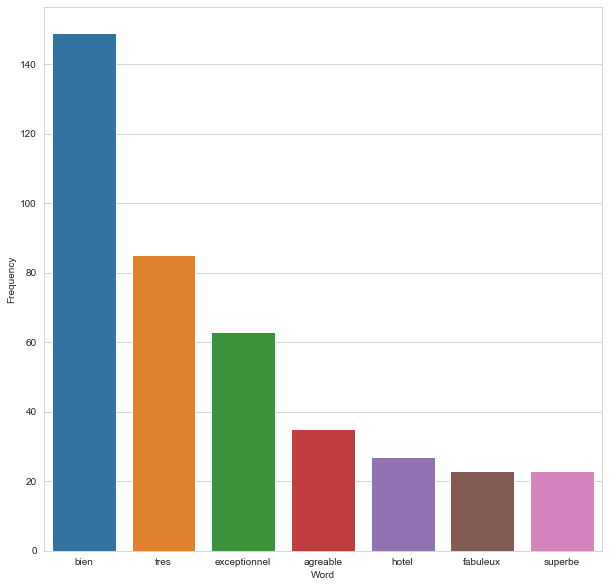

In [23]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

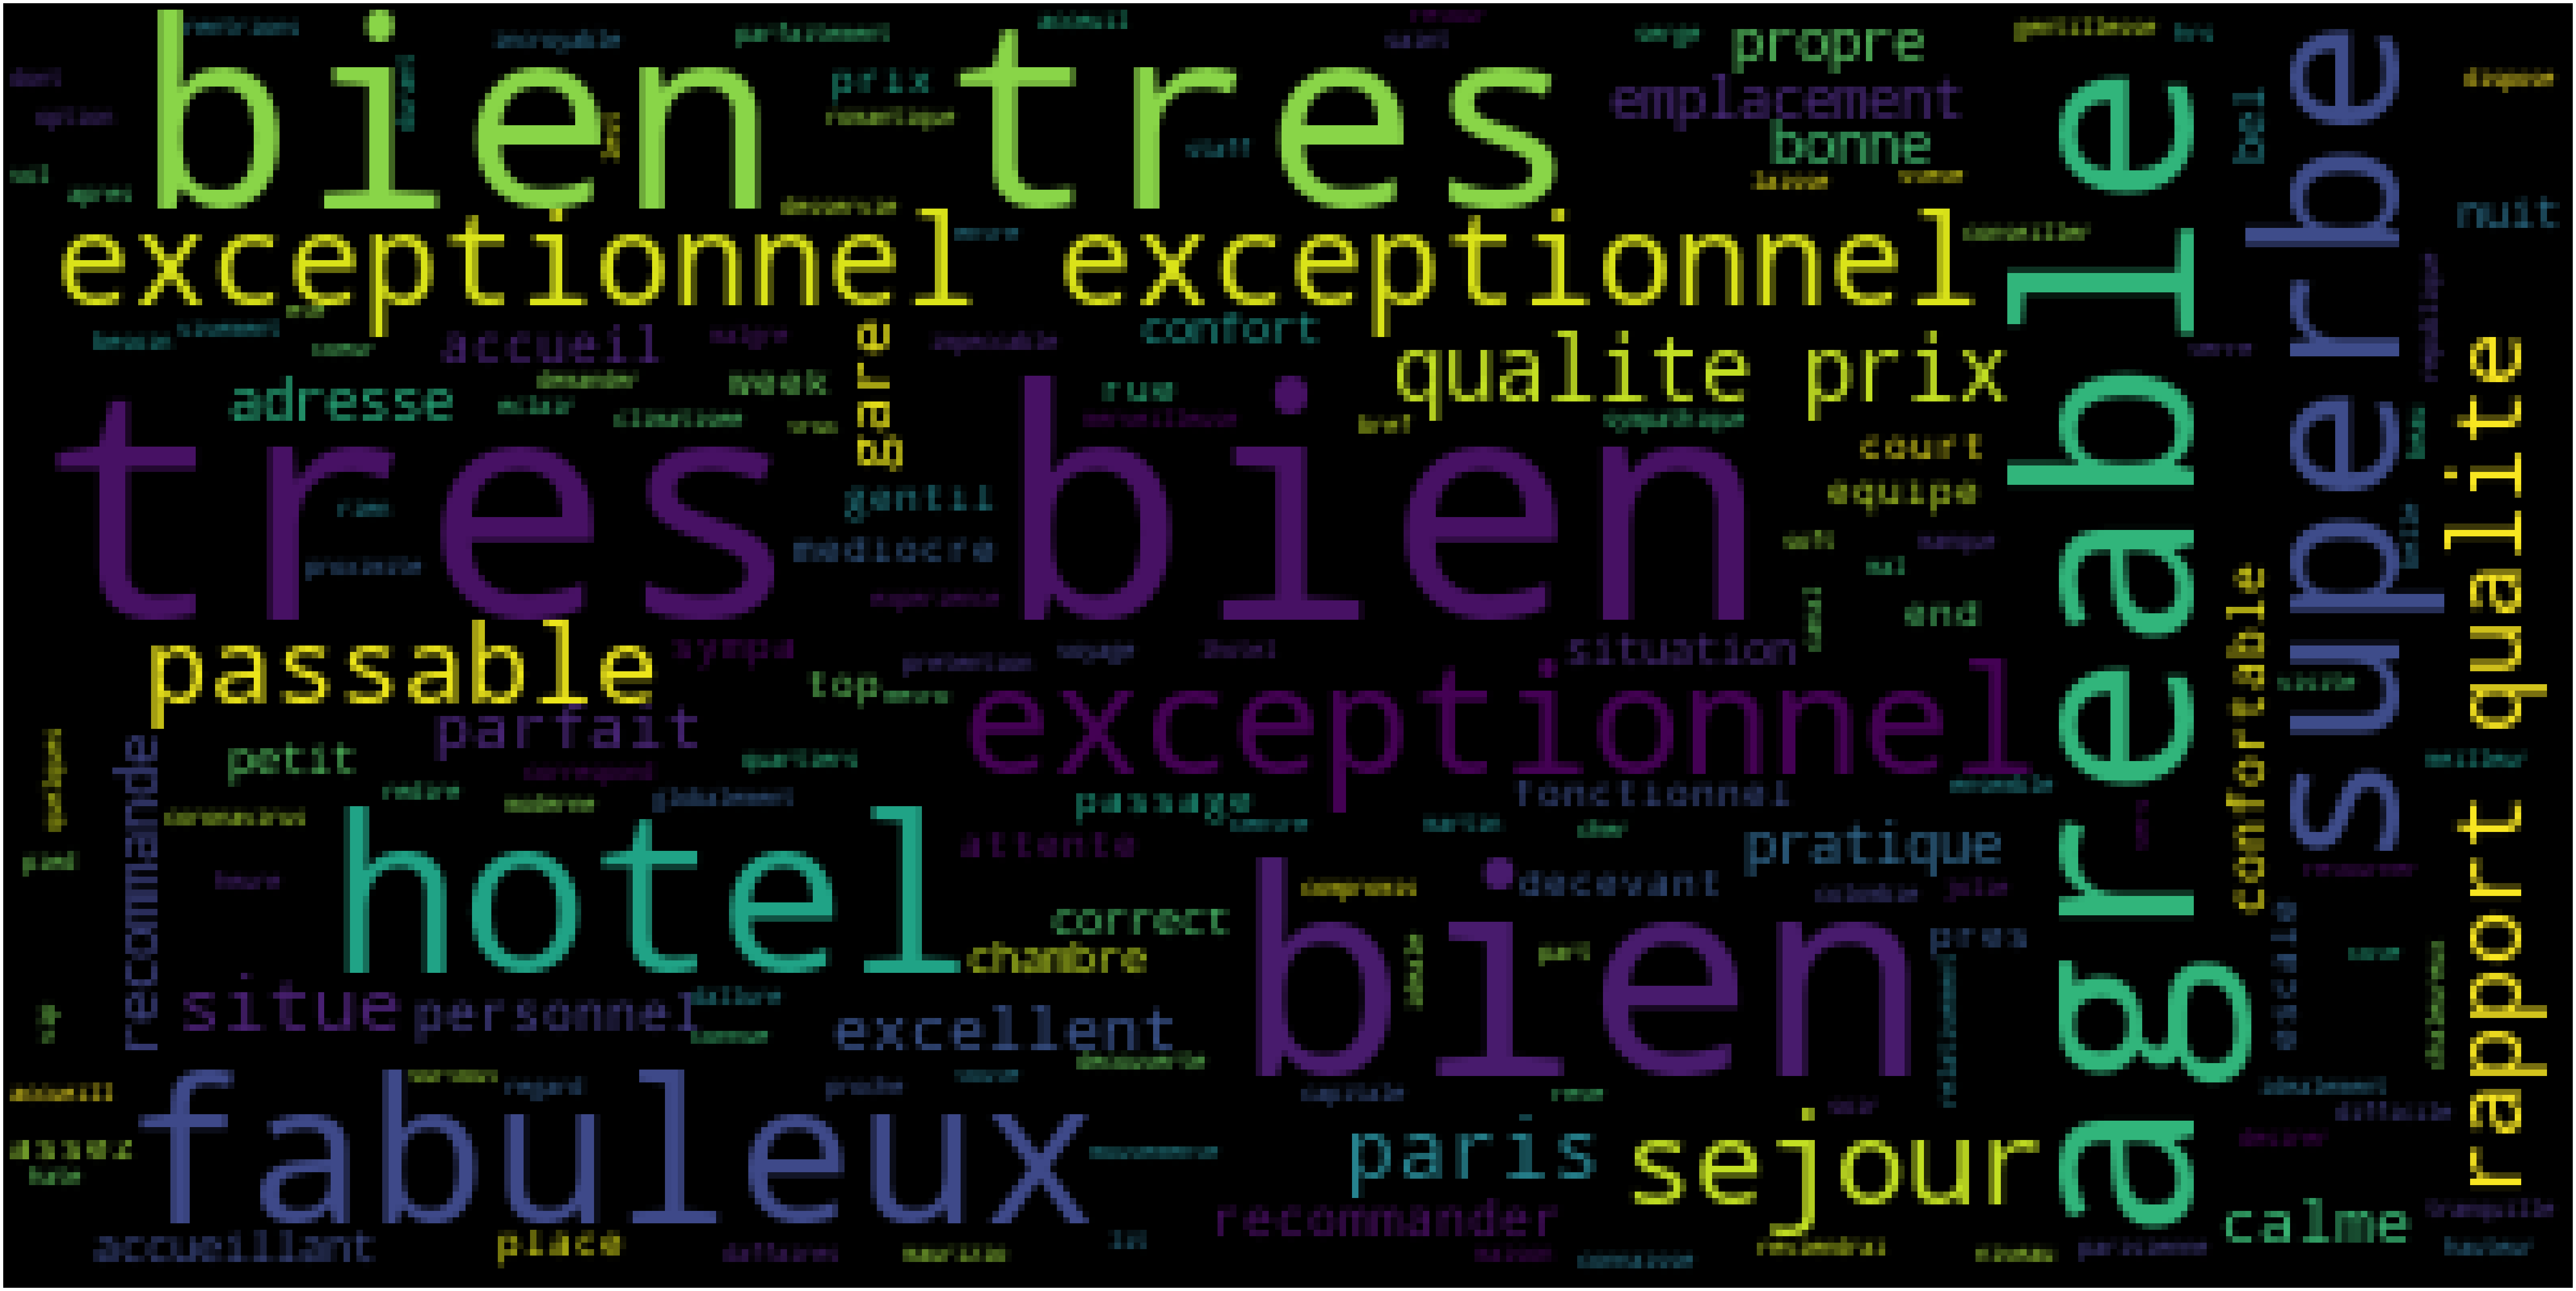

In [24]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [25]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['bons_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-z]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [26]:
#supprimer les caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [27]:
rslt.head(7)

,Word,Frequency
0,client,147
1,laisse,146
2,commentaire,146
3,tres,144
4,personnel,90
5,chambre,85
6,accueil,72


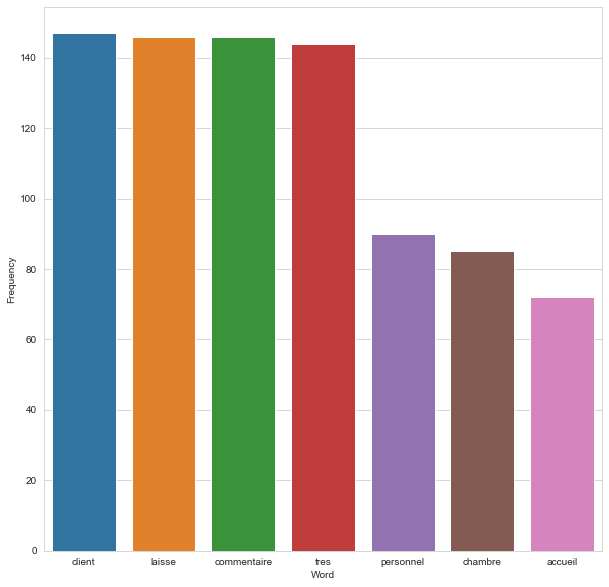

In [28]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

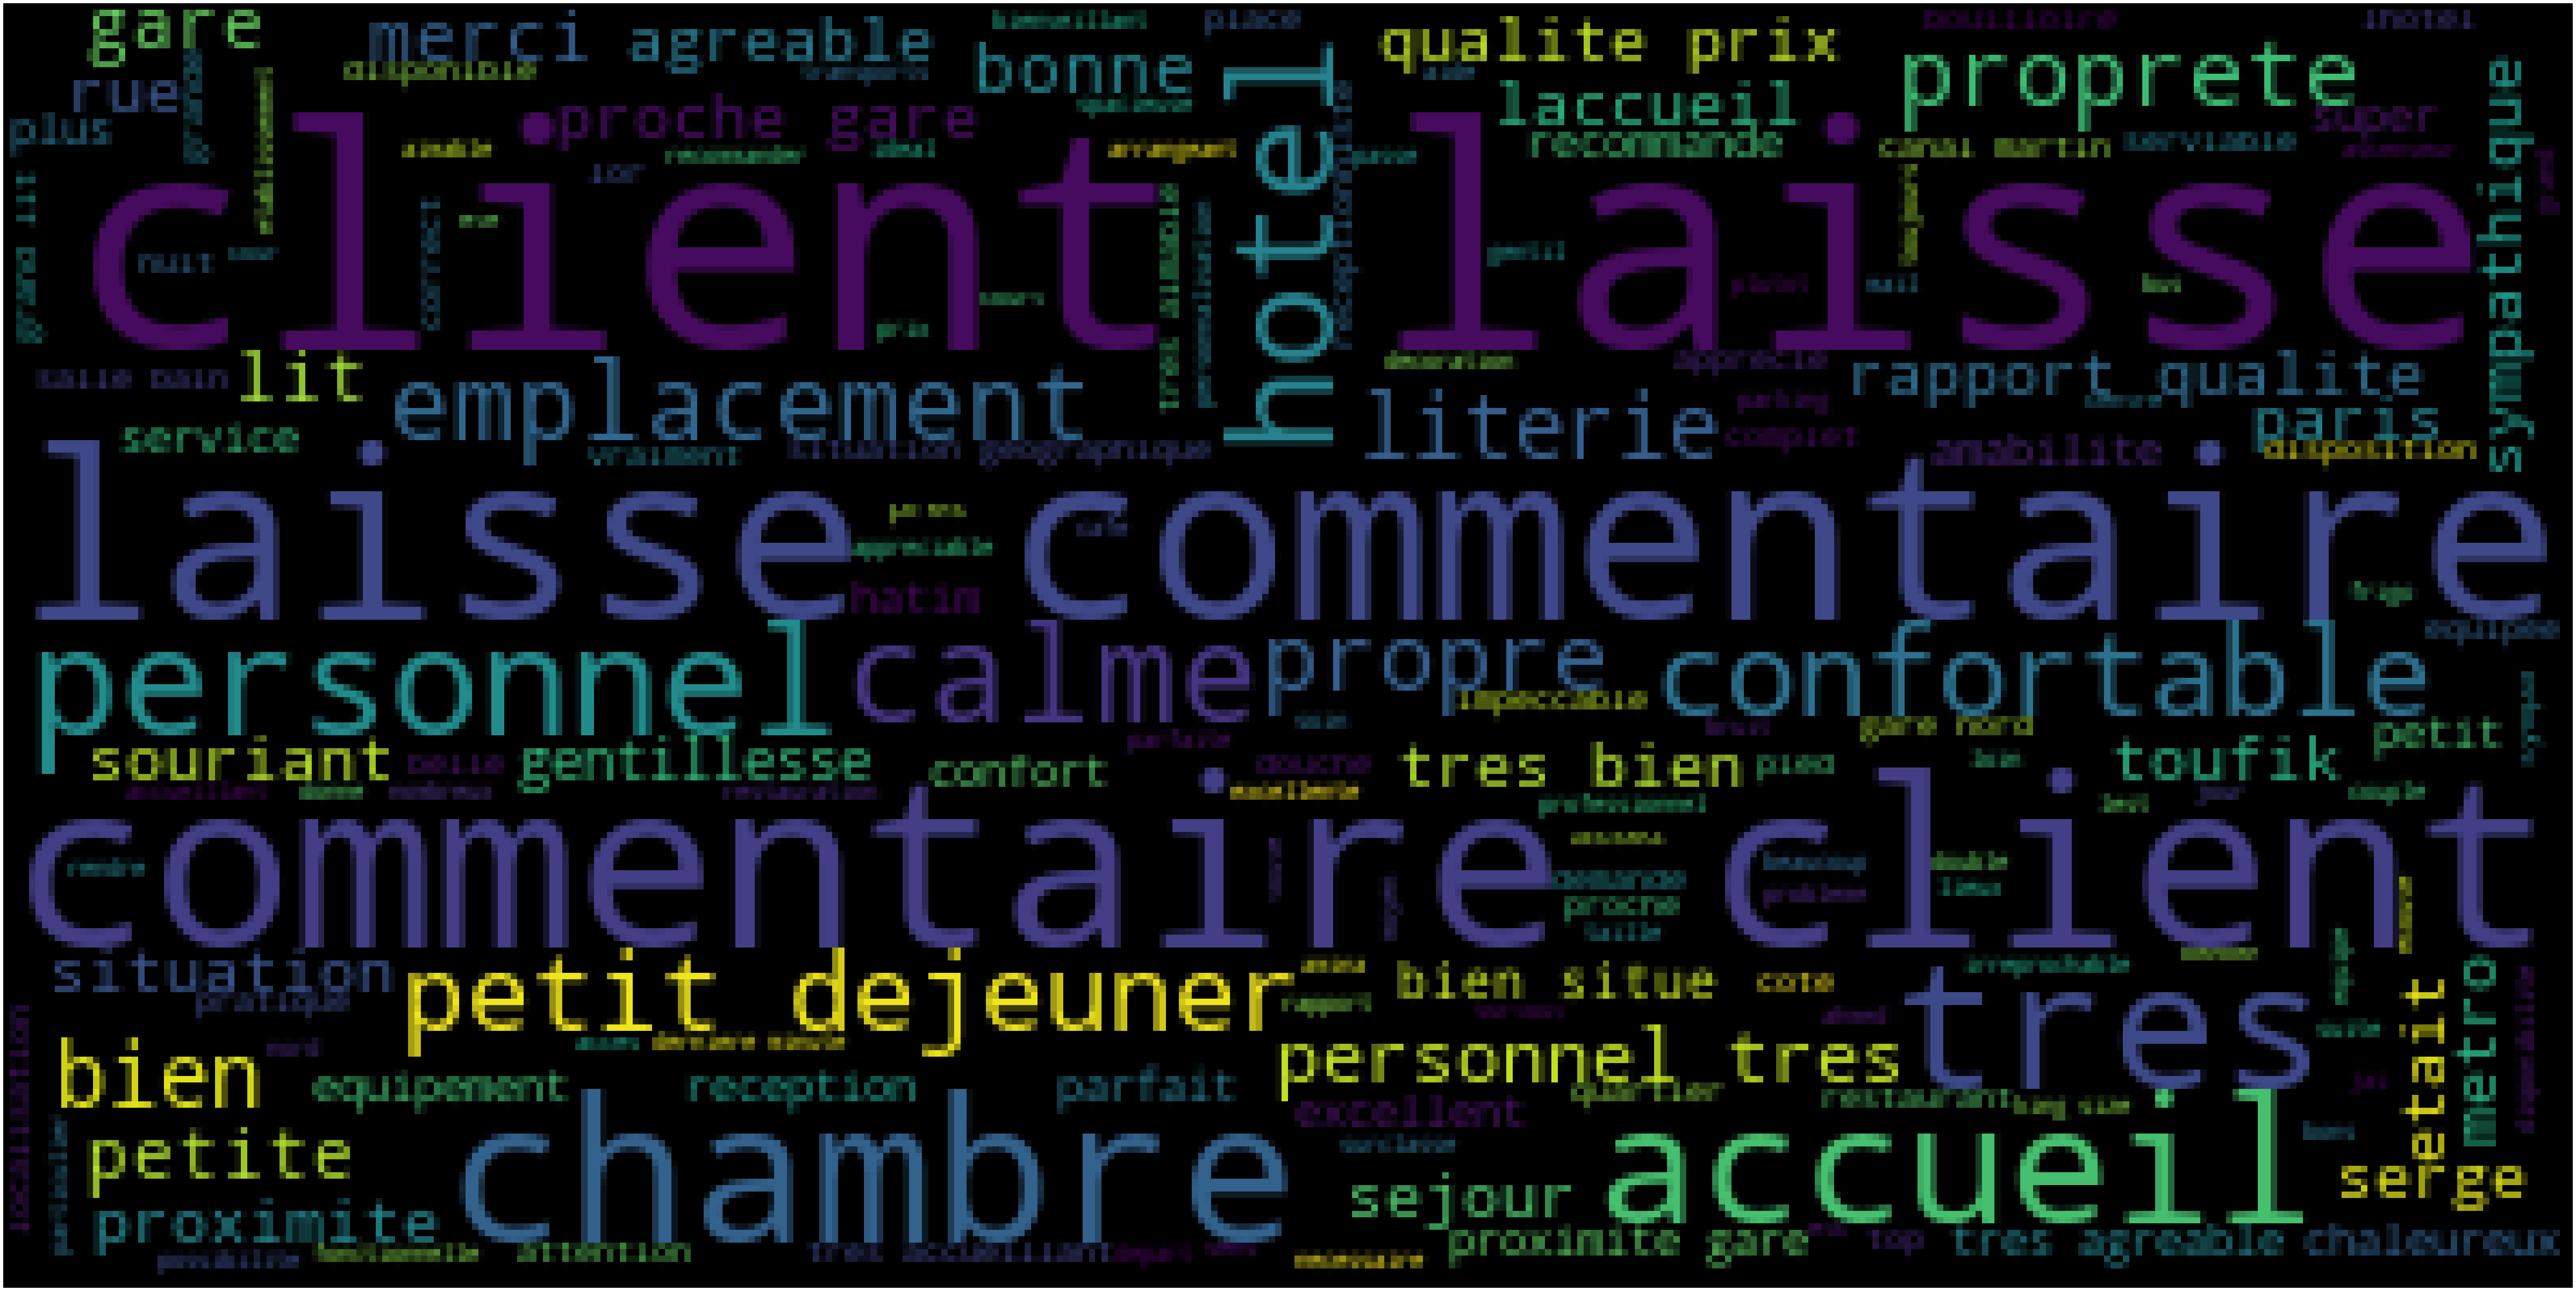

In [29]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [30]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['mauvais_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-z]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [31]:
#supprimer caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [32]:
rslt.head(7)

,Word,Frequency
0,chambre,61
1,petit,41
2,tres,36
3,dejeuner,35
4,petite,32
5,salle,26
6,etait,20


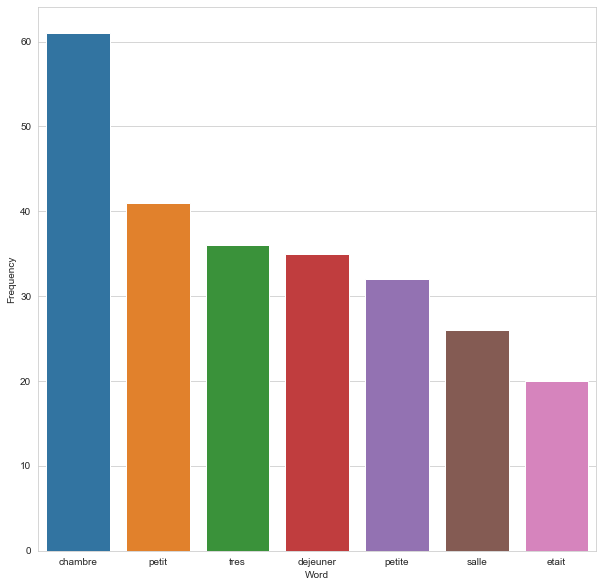

In [33]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

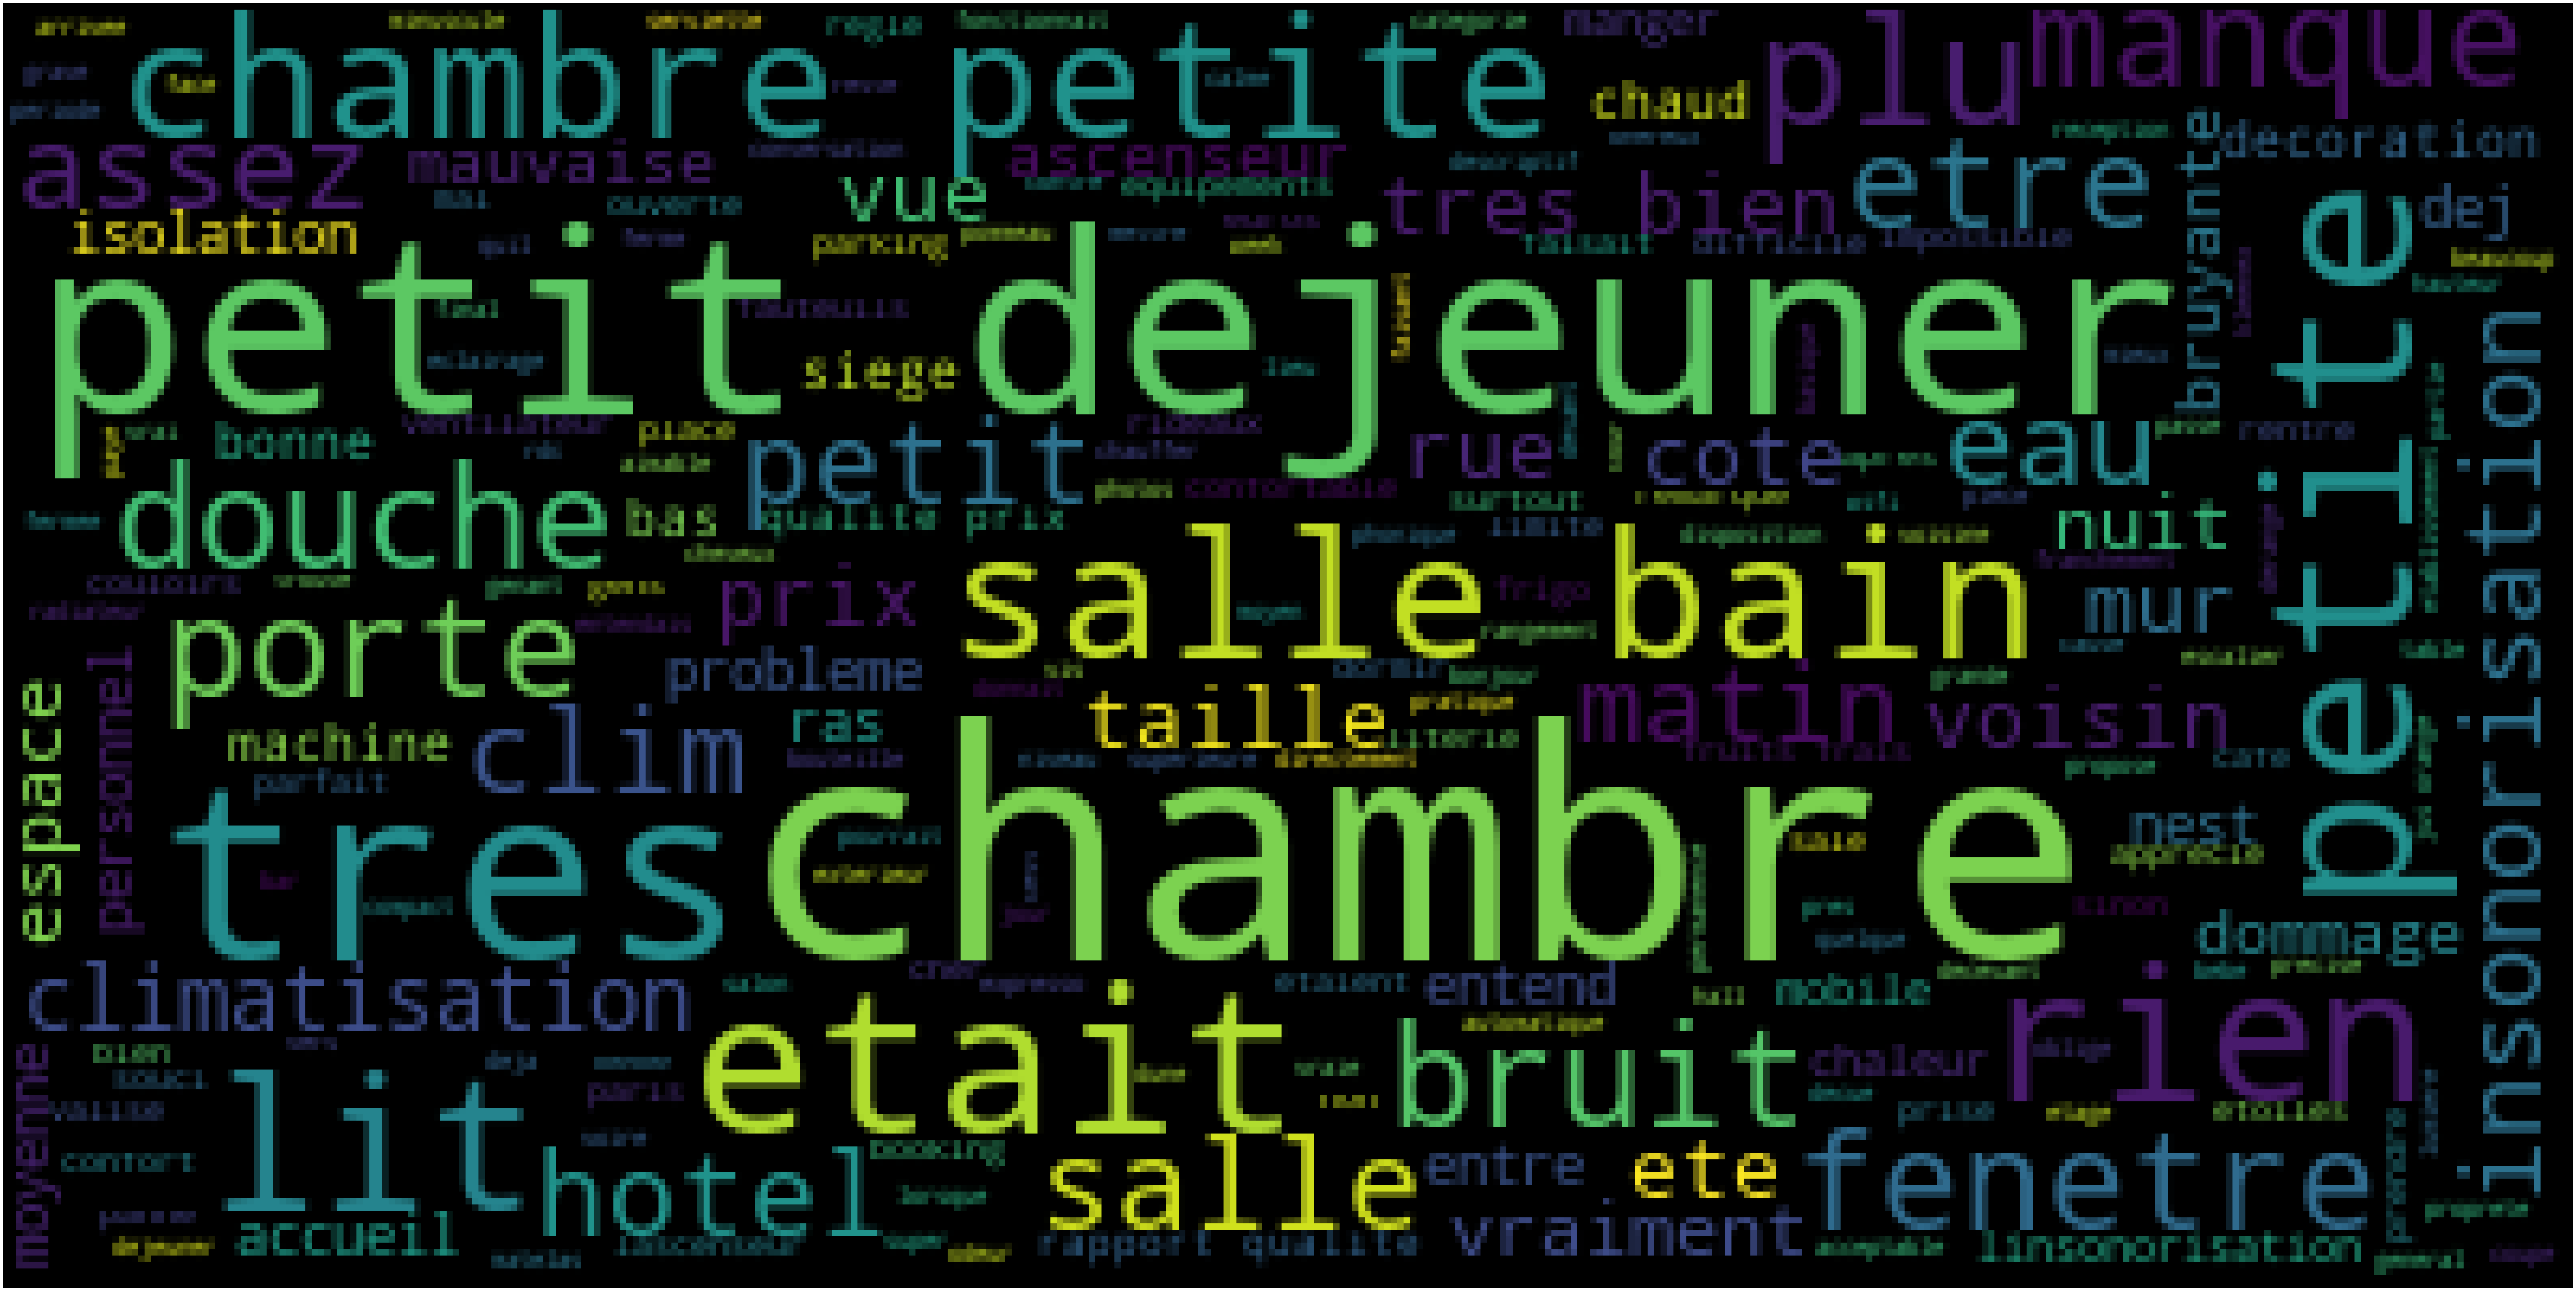

In [34]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [35]:
#vérification que les NaN dans la colonne 'mauvais points' ont bien de façon certaine une polarité de zéro pour TextBlob, 
#sentiment[0]=polarite et sentiment[1]=subjectivité
text = u"NaN"
blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
blob.sentiment
print('NaN a une polarité de {} et une subjectivité de {}.'.format(blob.sentiment[0], blob.sentiment[1]))

NaN a une polarité de 0.0 et une subjectivité de 0.0.


In [36]:
#chargement du dataframe pour avoir de nouveau les accents
df = pd.read_csv(r"C:\Users\utilisateur\Desktop\booking.csv", na_values=['None'], decimal=',')

In [37]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df22 = pd.DataFrame(df, columns= ['titre', 'bons_points', 'mauvais_points'])

df21 = df22['titre'].map(str) + ' ' + df22['bons_points'].map(str) + ' ' + df22['mauvais_points'].map(str)

print(df21)

bloblist_desc = list()

df_str=df21.astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    #df_polarity_desc1 = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

0      Le confort comme à la maison ! J'ai énormément...
1      Calme et confortable. Très bon accueil, Hatim ...
2      Accueil chaleureux - Personnel irréprochable :...
3      Très correct Merci a Hatim pour l'accueil, trè...
4      Très bien L’accueil , la situation de l’établi...
                             ...                        
384    Agréable Ce client n'a pas laissé de commentai...
385    Passable Ce client n'a pas laissé de commentai...
386    Exceptionnel Ce client n'a pas laissé de comme...
387    Agréable Ce client n'a pas laissé de commentai...
388    Agréable Ce client n'a pas laissé de commentai...
Length: 389, dtype: object
0.285
0.35428571428571426
0.015833333333333324
0.34375
0.0
0.21
1.0
0.33
0.011428571428571427
0.3392307692307692
0.21666666666666665
0.5874999999999999
0.24428571428571424
0.43000000000000005
0.5931249999999999
0.30375
0.375
0.2333333333333333
0.11200000000000002
0.32049999999999995
0.1
0.3741666666666667
0.27954545454545454
0.405
0.28545454545

In [38]:
df_polarity_desc1 = pd.DataFrame(data = bloblist_desc)
df_polarity_desc1.columns = ['sentiment']
df_polarity_desc1.head()

,sentiment
0,0.285000
1,0.354286
2,0.015833
3,0.343750
4,0.000000


In [39]:
def f(df_polarity_desc1):
    if df_polarity_desc1['sentiment'] > 0:
        val = "positive"
    elif df_polarity_desc1['sentiment'] <= 0:
        val = "negative"
    return val

df_polarity_desc1.apply(f, axis=1)

0      positive
1      positive
2      positive
3      positive
4      negative
         ...   
384    positive
385    negative
386    positive
387    positive
388    positive
Length: 389, dtype: object

In [40]:
df_polarity_desc1['polarite']=df_polarity_desc1.apply(f, axis=1)

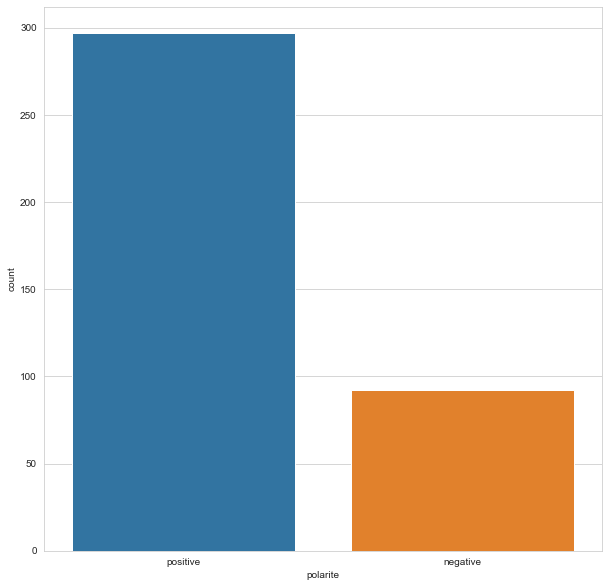

In [41]:
df_polarity_desc1.head()
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="polarite", data=df_polarity_desc1)

In [42]:
df_polarity_desc1.head()

,sentiment,polarite
0,0.285000,positive
1,0.354286,positive
2,0.015833,positive
3,0.343750,positive
4,0.000000,negative


In [43]:
df_polarity_desc1.columns

Index(['sentiment', 'polarite'], dtype='object')

In [44]:
#Transformation des valeurs de la variable polarite en 1 et 0
#pas besoin d'utiliser le module scikit-learn car on peut le faire directement 
df_polarity_desc1['polarite'] = np.where(df_polarity_desc1['polarite'] == 'positive', 1, 0)
df_polarity_desc1 = df_polarity_desc1.reset_index(drop=True)
df_polarity_desc1.head()

,sentiment,polarite
0,0.285000,1
1,0.354286,1
2,0.015833,1
3,0.343750,1
4,0.000000,0


In [45]:
df_polarity_desc1.drop(['sentiment'],1,inplace=True)
df_polarity_desc1.head()

,polarite
0,1
1,1
2,1
3,1
4,0


In [46]:
df21.head()
comments = pd.DataFrame(data=df21)
comments.columns = ['sentences']
comments.head()

,sentences
0,Le confort comme à la maison ! J'ai énormément...
1,"Calme et confortable. Très bon accueil, Hatim ..."
2,Accueil chaleureux - Personnel irréprochable :...
3,"Très correct Merci a Hatim pour l'accueil, trè..."
4,"Très bien L’accueil , la situation de l’établi..."


In [47]:
# fusion des deux datasets en un seul que l'on nommera df
df = pd.concat([df_polarity_desc1, comments], axis = 1)
df.head()

,polarite,sentences
0,1,Le confort comme à la maison ! J'ai énormément...
1,1,"Calme et confortable. Très bon accueil, Hatim ..."
2,1,Accueil chaleureux - Personnel irréprochable :...
3,1,"Très correct Merci a Hatim pour l'accueil, trè..."
4,0,"Très bien L’accueil , la situation de l’établi..."


In [48]:
df.columns=['sentiment', 'sentence']
df.head()

,sentiment,sentence
0,1,Le confort comme à la maison ! J'ai énormément...
1,1,"Calme et confortable. Très bon accueil, Hatim ..."
2,1,Accueil chaleureux - Personnel irréprochable :...
3,1,"Très correct Merci a Hatim pour l'accueil, trè..."
4,0,"Très bien L’accueil , la situation de l’établi..."


<h1>3. Machine learning</h1>

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df[["sentence"]], df['sentiment'])

In [50]:
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train['sentence'])
feat_train = pipe.transform(X_train['sentence'])
feat_train.shape

(291, 1199)

In [51]:
feat_train.min(), feat_train.max()

(0.0, 0.7527279588161578)

In [52]:
feat_test = pipe.transform(X_test['sentence'])
feat_test.shape

(98, 1199)

In [53]:
dt = DecisionTreeClassifier()
dt.fit(feat_train, y_train)
dt.score(feat_test, y_test)

0.9081632653061225

In [54]:
DecisionTree = dt.fit(feat_train, y_train)

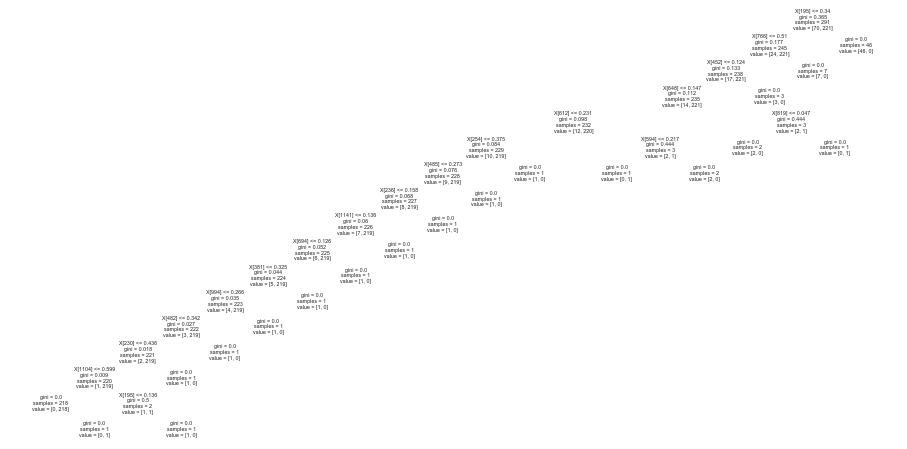

In [55]:
from sklearn import tree
fig=plt.figure(figsize=(16,8))
fig=tree.plot_tree(DecisionTree)
plt.show()

In [114]:
def MatriceConfusion (model):
    y_pred = model.predict(feat_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

[[17  5]
 [ 2 74]]


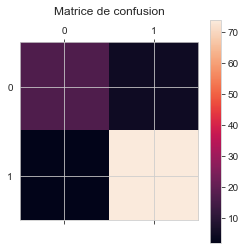

In [115]:
y_pred = MatriceConfusion(DecisionTree)

In [56]:
param_grid = {'max_depth' : [3, 10, 15],
    'random_state': [0, 42],
             'n_estimators' : [10, 50]}
grid = GridSearchCV( RandomForestClassifier(), param_grid)

%time grid.fit(feat_train, y_train)
print(grid.best_params_)

model = grid.best_estimator_
yfit = model.predict(feat_test)

Wall time: 4 s
{'max_depth': 15, 'n_estimators': 10, 'random_state': 0}


In [117]:
clf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
clf = clf.fit(feat_train, y_train)
clf.score(feat_test, y_test)

0.9489795918367347

In [58]:
score = clf.predict_proba(feat_test)
print(score[0])

[0.91736265 0.08263735]


In [59]:
score = clf.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])

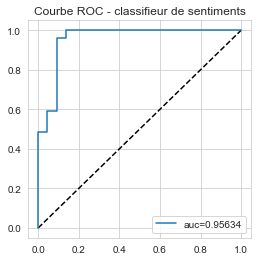

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

[[17  5]
 [ 0 76]]


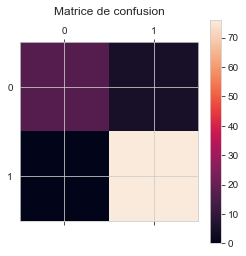

In [118]:
y_pred = MatriceConfusion(clf)

In [61]:
feat_test.shape

(98, 1199)

In [62]:
lr = LogisticRegression()
lr.fit(feat_train, y_train)
lr.score(feat_test, y_test)

0.9489795918367347

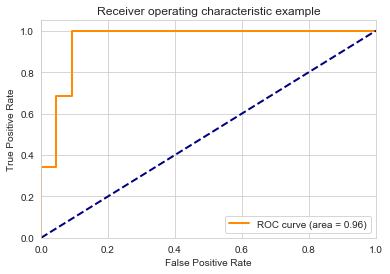

In [63]:
#X_train, X_test, Y_train, Y_test
'''ROC curve'''
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

lr = lr.fit(feat_train, y_train)
y_score = lr.decision_function(feat_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[17  5]
 [ 0 76]]


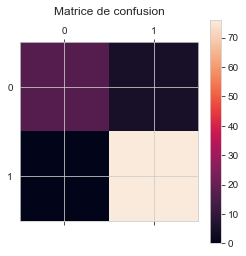

In [65]:
y_pred = MatriceConfusion(lr)

In [66]:
mnb = MultinomialNB()
mnb.fit(feat_train, y_train)
mnb.score(feat_test, y_test)

0.7959183673469388

In [119]:
from sklearn.model_selection import GridSearchCV
    
# defining parameter range
param_grid = {'C': [10, 50, 100,200],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid']
             }
clf = svm.SVC()
clf_grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3,cv=3)
 
# fitting the model for grid search
svm = clf_grid.fit(feat_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=10, kernel=rbf ................................................
[CV] .................... C=10, kernel=rbf, score=0.969, total=   0.0s
[CV] C=10, kernel=rbf ................................................
[CV] .................... C=10, kernel=rbf, score=0.928, total=   0.0s
[CV] C=10, kernel=rbf ................................................
[CV] .................... C=10, kernel=rbf, score=0.948, total=   0.0s
[CV] C=10, kernel=sigmoid ............................................
[CV] ................ C=10, kernel=sigmoid, score=0.918, total=   0.0s
[CV] C=10, kernel=sigmoid ............................................
[CV] ................ C=10, kernel=sigmoid, score=0.918, total=   0.0s
[CV] C=10, kernel=sigmoid ............................................
[CV] ................ C=10, kernel=sigmoid, score=0.938, total=   0.0s
[CV] C=50, kernel=rbf ................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] ............... C=100, kernel=sigmoid, score=0.938, total=   0.0s
[CV] C=200, kernel=rbf ...............................................
[CV] ................... C=200, kernel=rbf, score=0.969, total=   0.0s
[CV] C=200, kernel=rbf ...............................................
[CV] ................... C=200, kernel=rbf, score=0.928, total=   0.0s
[CV] C=200, kernel=rbf ...............................................
[CV] ................... C=200, kernel=rbf, score=0.948, total=   0.0s
[CV] C=200, kernel=sigmoid ...........................................
[CV] ............... C=200, kernel=sigmoid, score=0.918, total=   0.0s
[CV] C=200, kernel=sigmoid ...........................................
[CV] ............... C=200, kernel=sigmoid, score=0.928, total=   0.0s
[CV] C=200, kernel=sigmoid ...........................................
[CV] ............... C=200, kernel=sigmoid, score=0.938, total=   0.0s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s finished


In [68]:
print(clf_grid.best_score_.round(2))
print(clf_grid.best_params_)

0.95
{'C': 10, 'kernel': 'rbf'}


In [69]:
final_model = clf_grid.best_estimator_

In [70]:
pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

In [71]:
from sklearn.metrics import classification_report
# print classification report
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00       221

    accuracy                           1.00       291
   macro avg       1.00      1.00      1.00       291
weighted avg       1.00      1.00      1.00       291



In [72]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        22
           1       0.94      1.00      0.97        76

    accuracy                           0.95        98
   macro avg       0.97      0.89      0.92        98
weighted avg       0.95      0.95      0.95        98



In [ ]:
y_pred = MatriceConfusion(lr)

In [73]:
import sklearn.naive_bayes as nb
naivebayes = nb.BernoulliNB()

naivebayes_fit = naivebayes.fit(feat_train, y_train)

In [74]:
pred_train = naivebayes.predict(feat_train)
pred_test = naivebayes.predict(feat_test)

In [75]:
from sklearn import metrics
metrics.accuracy_score(y_train, pred_train)

0.7697594501718213

In [76]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.51      0.84      0.64        70
           1       0.94      0.75      0.83       221

    accuracy                           0.77       291
   macro avg       0.73      0.79      0.73       291
weighted avg       0.84      0.77      0.78       291



In [77]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.58      0.82      0.68        22
           1       0.94      0.83      0.88        76

    accuracy                           0.83        98
   macro avg       0.76      0.82      0.78        98
weighted avg       0.86      0.83      0.84        98



In [78]:
from sklearn.ensemble import GradientBoostingClassifier
gbc40 = GradientBoostingClassifier(n_estimators=200, max_depth=40)
gbc40.fit(feat_train, y_train)
gbc40.score(feat_test, y_test)

0.9285714285714286

In [79]:
generated_ngrams = ngrams(word_tokenize(X_train.iloc[0,0]), 3, pad_left=True, pad_right=True)
list(generated_ngrams)[:7]

[(None, None, 'Très'),
 (None, 'Très', 'bien'),
 ('Très', 'bien', 'Ce'),
 ('bien', 'Ce', 'client'),
 ('Ce', 'client', 'n'),
 ('client', 'n', "'"),
 ('n', "'", 'a')]

In [80]:
pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                      TfidfTransformer())
pipe2.fit(X_train['sentence'])
feat_train2 = pipe2.transform(X_train['sentence'])
feat_train2.shape

(291, 4938)

In [81]:
cl = pipe2.steps[0]
cl[1].get_feature_names()[:10]

['100',
 '100 les',
 '100 minutes',
 '110',
 '110 sous',
 '120',
 '120 euros',
 '12euros',
 '12euros est',
 '14h00']

In [82]:
feat_test2 = pipe2.transform(X_test['sentence'])

In [83]:
clf2 = LogisticRegression()
clf2.fit(feat_train2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
clf2.score(feat_test2, y_test)

0.9489795918367347

In [86]:
pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train['sentence'])
feat_train_svd = pipe_svd.transform(X_train['sentence'])
feat_train_svd.shape

(291, 291)

In [87]:
clf_svd = RandomForestClassifier(n_estimators=50)
clf_svd.fit(feat_train_svd, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [89]:
feat_test_svd = pipe_svd.transform(X_test['sentence'])
clf_svd.score(feat_test_svd, y_test)

0.9489795918367347

In [90]:
lr_svd = LogisticRegression()
lr_svd.fit(feat_train_svd, y_train)
lr_svd.score(feat_test_svd, y_test)

0.9489795918367347

In [91]:
pipe_svd_tfidf = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     TruncatedSVD(n_components=300))
pipe_svd_tfidf.fit(X_train['sentence'])
feat_train_svd_tfidf = pipe_svd_tfidf.transform(X_train['sentence'])

clf_svd_tfidf = LogisticRegression()
clf_svd_tfidf.fit(feat_train_svd_tfidf, y_train)

feat_test_svd_tfidf = pipe_svd_tfidf.transform(X_test['sentence'])
clf_svd_tfidf.score(feat_test_svd_tfidf, y_test)

0.9489795918367347

In [92]:
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X_train['sentence']]
sentance[0]

['tres',
 'bien',
 'ce',
 'client',
 'n',
 'a',
 'pas',
 'laisse',
 'de',
 'commentaire',
 'nan']

In [93]:
model = word2vec.Word2Vec(sentance, size=300, window=20,
                          min_count=2, workers=1, iter=100)
model.corpus_count

291

In [94]:
vocab = model.wv.vocab
list(vocab)[:5]

['tres', 'bien', 'ce', 'client', 'n']

In [95]:
model.save('trained_word2vec.bin')

In [96]:
model.wv['exceptionnel'].shape, model.wv['exceptionnel'][:10]

((300,),
 array([-0.07382755,  0.6689941 ,  0.31225458, -0.11405301,  0.15742132,
        -0.18729733,  0.06833952,  0.28015462,  0.03705578,  0.23112787],
       dtype=float32))

In [97]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = numpy.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train["sentence"], model)
wv_train_feat.shape

(291, 300)

In [98]:
clfwv = LogisticRegression(solver='lbfgs', max_iter=1000)
clfwv.fit(wv_train_feat, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
wv_test_feat = word2vec_features(X_test["sentence"], model)

In [100]:
clfwv.score(wv_test_feat, y_test)

0.8571428571428571

In [101]:
words = list(sorted(model.wv.vocab))
words[:10]

['a',
 'acceptable',
 'acces',
 'accessible',
 'acceuil',
 'acceuillant',
 'accueil',
 'accueillant',
 'adresse',
 'affaires']

In [102]:
subset = ['exceptionnel', 'client', words[3], words[4], words[5]]
rows = []
for w in subset:
    for ww in subset:
        rows.append(dict(w1=w, w2=ww, d=model.wv.similarity(w, ww)))
import pandas
pandas.DataFrame(rows).pivot("w1", "w2", "d")

w2,accessible,acceuil,acceuillant,client,exceptionnel
w1,,,,,
accessible,1.000000,0.320146,0.272662,-0.336508,-0.158759
acceuil,0.320146,1.000000,0.068514,0.302789,-0.306724
acceuillant,0.272662,0.068514,1.000000,-0.066239,0.057888
client,-0.336508,0.302789,-0.066239,1.000000,0.545933
exceptionnel,-0.158759,-0.306724,0.057888,0.545933,1.000000


In [103]:
# y variable dépendante et X variables indépendantes
#X = df.iloc[:, df.columns !='polaritecomments'].values
#y = df.iloc[:, 5].values

In [104]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#print (X_train.shape,y_train.shape)
#print (X_test.shape, y_test.shape)

In [105]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [106]:
#train = pd.DataFrame(X_train)

In [107]:
#train.hist(figsize=(13,50),color='blue',bins=40,layout=(8,3))
#plt.show()

In [108]:
#param_grid = {'max_depth' : [3, 10, 15],
#    'random_state': [0, 42],
#             'n_estimators' : [10, 50]}
#grid = GridSearchCV( RandomForestClassifier(), param_grid)

#%time grid.fit(X_train, y_train)
#print(grid.best_params_)

#model = grid.best_estimator_
#yfit = model.predict(X_test)

In [109]:
#weights = (y == 0).sum() / (1.0 * (y == 1).sum())

In [110]:
#def get_score(model,X_train,X_test,y_train,y_test):
    #model.fit(X_train,y_train)
    #return model.score(X_test,y_test)

In [111]:
kf = KFold(n_splits=3)

LR = LogisticRegression()
SVM = SVC()
NB = nb.BernoulliNB()
DTC = DecisionTreeClassifier(max_depth = 5, random_state= 42)
RF = RandomForestClassifier(max_depth = 5, n_estimators= 10, random_state= 42)
XGBC = XGBClassifier(max_depth = 5, scale_pos_weight = weights, \
                n_jobs = 4)

logis=list()
svm=list()
nb=list()
arb=list()
rfl=list()
clf=list()

for index_train, index_test in kf.split(d_model):
    X_train, X_test, y_train, y_test = X[index_train], X[index_test], y[index_train], y[index_test]
    logis.append(get_score(LR, X_train, X_test, y_train, y_test))
    svm.append(get_score(SVM, X_train, X_test, y_train, y_test))
    nb.append(get_score(NB, X_train, X_test, y_train, y_test))
    arb.append(get_score(DTC, X_train, X_test, y_train, y_test))
    rfl.append(get_score(RF, X_train, X_test, y_train, y_test))
    clf.append(get_score(XGBC, X_train, X_test, y_train, y_test))
    
print(np.mean(logis))
print(np.mean(svm))
print(np.mean(arb))
print(np.mean(rfl))
print(np.mean(clf))

NameError: name 'weights' is not defined

In [ ]:
# y variable dépendante et X variables indépendantes
X = d_model.iloc[:, d_model.columns !='isFraud']
Y = d_model.iloc[:, 5]

X_t = pd.DataFrame(X_train)
feature_importances = pd.DataFrame(RF.feature_importances_, index = X.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

In [ ]:
features = X.columns
importances=RF.feature_importances_
indices=np.argsort(importances)
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('importance du score');
plt.ylabel('variables indépendantes');
plt.title('Ordre d\'importance des variables indépendantes');
plt.show()

In [ ]:
def MatriceConfusion (model):
    y_pred = model.predict(X_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

In [ ]:
y_pred = MatriceConfusion(LR)